In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions

from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = [16.18033, 10]    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100

In [6]:
data = pd.read_csv("/Users/weilu/Research/data/survey_represent_x_com_complete.csv", index_col=0)
res_type_list = ['GLY', 'ALA', 'VAL', 'CYS', 'PRO', 'LEU', 'ILE', 'MET', 'TRP', 'PHE', 'SER', 'THR', 'TYR', 'GLN', 'ASN', 'LYS', 'ARG', 'HIS', 'ASP', 'GLU']


In [7]:
import pickle
from sklearn.mixture import GaussianMixture

for res_type in res_type_list:
    if res_type == "GLY":
        continue
    data_res = data.query(f"ResName == '{res_type}'").reset_index(drop=True)

    X = data_res[["r1", "r2", "r3"]].values

    gmm = GaussianMixture(n_components=3).fit(X)

    n_features = 3
    matrix_chol = gmm.precisions_cholesky_
    n_components, _ = gmm.means_.shape
    n_components, _, _ = matrix_chol.shape
    log_det_chol = (np.sum(np.log(
        matrix_chol.reshape(
            n_components, -1)[:, ::n_features + 1]), 1))
    log_det = log_det_chol

    means = gmm.means_
    precisions_chol = gmm.precisions_cholesky_
    weights = gmm.weights_
    np.savetxt(f"/Users/weilu/opt/parameters/side_chain/{res_type}_means.txt", means, fmt='%10.8f')
    np.savetxt(f"/Users/weilu/opt/parameters/side_chain/{res_type}_precisions_chol.txt", precisions_chol.reshape(3,9), fmt='%12.8f')
    np.savetxt(f"/Users/weilu/opt/parameters/side_chain/{res_type}_log_det.txt", log_det, fmt='%10.8f')
    np.savetxt(f"/Users/weilu/opt/parameters/side_chain/{res_type}_weights.txt", weights, fmt='%10.8f')
    
    with open(f"/Users/weilu/opt/parameters/side_chain/gmm_{res_type}.pkl",'wb') as f:
      pickle.dump(gmm, f)

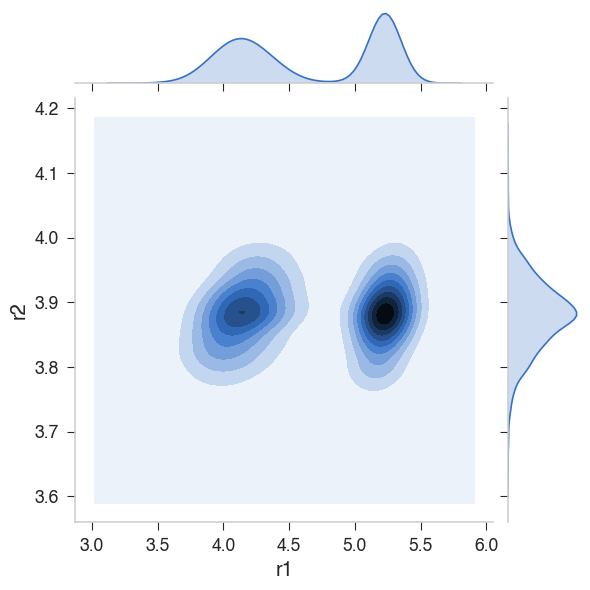

In [40]:
data_res = data.query("ResName == 'TYR'").reset_index(drop=True)
sns.jointplot("r1", "r2", kind="kde", data=data_res)
# plt.show()

In [124]:
def get_parameters(X):
    n_components = 3
    gmm = GaussianMixture(n_components=n_components).fit(X)

    n_features = 3
    matrix_chol = gmm.precisions_cholesky_
    n_components, _ = gmm.means_.shape
    n_components, _, _ = matrix_chol.shape
    log_det_chol = (np.sum(np.log(
        matrix_chol.reshape(
            n_components, -1)[:, ::n_features + 1]), 1))
    log_det = log_det_chol

    means = gmm.means_
    precisions_chol = gmm.precisions_cholesky_
    weights = gmm.weights_
    print(means, precisions_chol, weights)
    return gmm, means, precisions_chol, weights

In [125]:
gmm, means, precisions_chol, weights = get_parameters(data_res[["r1", "r2", "r3"]].values)

[[4.1477059  3.87660711 5.26290152]
 [5.22568112 3.87951258 4.01458734]
 [4.15129429 3.9084444  4.11559124]] [[[  5.0344189   -2.40738223   6.79789195]
  [  0.          19.59680227 -32.00419269]
  [  0.           0.          30.49647854]]

 [[ 18.59864135 -20.4711094   11.67192918]
  [  0.          26.7814915  -18.05971993]
  [  0.           0.           6.26333791]]

 [[  3.92653864  -1.70786655   8.21358263]
  [  0.          20.27387412 -25.01316343]
  [  0.           0.           8.06082409]]] [0.48324372 0.45737378 0.0593825 ]


In [126]:
gmm.score_samples([[r1_max, r2_max, r3_max]])

array([-35.90492634])

In [128]:
gmm.score_samples([[r1_min, r2_min, r3_min]])

array([-21.9753744])

In [127]:
a = gmm.sample(10000)[0]
a_data = pd.DataFrame(a, columns=["r1", "r2", "r3"])
fig = px.scatter_3d(a_data, x='r1', y='r2', z='r3', opacity=0.1)
fig.show()

In [114]:
a = gmm.sample(10000)[0]
a_data = pd.DataFrame(a, columns=["r1", "r2", "r3"])
fig = px.scatter_3d(a_data, x='r1', y='r2', z='r3', opacity=0.1)
fig.show()

In [52]:
r1_max, r2_max, r3_max = data_res[["r1", "r2", "r3"]].values.max(axis=0)
r1_min, r2_min, r3_min = data_res[["r1", "r2", "r3"]].values.min(axis=0)

In [86]:
fake_set = []
num = 10
for r1 in np.linspace(r1_min, r1_max, num):
    for r2 in np.linspace(r2_min, r2_max, num):
        for r3 in np.linspace(r3_min, r3_max, num):
            fake_set.append(["x", 0, "TYR", r1, r2, r3, 0])

In [88]:
fake.shape

(1000, 7)

In [107]:
fake_set = []
num = 5
r1_list = np.random.random(num) * (r1_max - r1_min) + r1_min
r2_list = np.random.random(num) * (r2_max - r2_min) + r2_min
r3_list = np.random.random(num) * (r3_max - r3_min) + r3_min
for r1 in r1_list:
    for r2 in r2_list:
        for r3 in r3_list:
            fake_set.append(["x", 0, "TYR", r1, r2, r3, 0])
fake = pd.DataFrame(fake_set, columns=['Protein', 'id', 'ResName', 'r1', 'r2', 'r3', 'r'])

In [108]:
data_res_and_fake = pd.concat([data_res, fake])

In [109]:
gmm, means, precisions_chol, weights = get_parameters(data_res_and_fake[["r1", "r2", "r3"]].values)

[[4.13712001 3.87588061 5.26756404]
 [5.2313387  3.87956037 3.99935791]
 [4.54737587 3.89389474 4.24547038]] [[[  5.42395335  -2.9013115    7.24958727]
  [  0.          20.51940964 -39.36198882]
  [  0.           0.          39.28737415]]

 [[ 24.34160308 -39.507847     2.5441254 ]
  [  0.          36.0227117  -13.76320193]
  [  0.           0.           7.08773502]]

 [[  1.82904497   0.04300245   0.10669425]
  [  0.           9.78680673  -0.60874225]
  [  0.           0.           1.96396971]]] [0.4474636  0.41532996 0.13720644]


In [110]:
a = gmm.sample(10000)[0]
a_data = pd.DataFrame(a, columns=["r1", "r2", "r3"])
fig = px.scatter_3d(a_data, x='r1', y='r2', z='r3', opacity=0.1)
fig.show()

In [48]:
import plotly.express as px
fig = px.scatter_3d(data_res, x='r1', y='r2', z='r3', opacity=0.1)
fig.show()

In [15]:
def compute_side_chain_energy_for_x(x, means, precisions_chol, log_det, weights):
    n_features = 3
    n_components, _ = means.shape

    mean_dot_precisions_chol = np.zeros((3,3))
    log_prob = np.zeros(3)
    for i in range(n_components):
        mean_dot_precisions_chol[i] = np.dot(means[i], precisions_chol[i])
        y = np.dot(x, precisions_chol[i]) - mean_dot_precisions_chol[i]
        log_prob[i] = np.sum(np.square(y))

    log_gaussian_prob = -.5 * (n_features * np.log(2 * np.pi) + log_prob) + log_det
    c = np.max(log_gaussian_prob + np.log(weights))
    score = np.log(np.sum(np.exp(log_gaussian_prob + np.log(weights) - c))) + c
    kt = 1
    E_side_chain = -score*kt
    # print(E_side_chain)
    return E_side_chain

In [17]:
means_dic = {}
precisions_chol_dic = {}
log_det_dic = {}
weights_dic = {}
for res_type in res_type_list:
    if res_type == "GLY":
        continue
        
    means = np.loadtxt(f"/Users/weilu/opt/parameters/side_chain/{res_type}_means.txt")
    precisions_chol = np.loadtxt(f"/Users/weilu/opt/parameters/side_chain/{res_type}_precisions_chol.txt").reshape(3,3,3)
    log_det = np.loadtxt(f"/Users/weilu/opt/parameters/side_chain/{res_type}_log_det.txt")
    weights = np.loadtxt(f"/Users/weilu/opt/parameters/side_chain/{res_type}_weights.txt")
    means_dic[res_type] = means
    
    precisions_chol_dic[res_type] = precisions_chol
    log_det_dic[res_type] = log_det
    weights_dic[res_type] = weights

In [141]:
means_all_res = np.zeros((20, 3, 3))
precisions_chol_all_res = np.zeros((20, 3, 3, 3))
log_det_all_res = np.zeros((20, 3))
weights_all_res = np.zeros((20, 3))

for i, res_type_one_letter in enumerate(res_type_map_letters):
    res_type = one_to_three(res_type_one_letter)
    if res_type == "GLY":
        continue
        
    means = np.loadtxt(f"/Users/weilu/opt/parameters/side_chain/{res_type}_means.txt")
    precisions_chol = np.loadtxt(f"/Users/weilu/opt/parameters/side_chain/{res_type}_precisions_chol.txt").reshape(3,3,3)
    log_det = np.loadtxt(f"/Users/weilu/opt/parameters/side_chain/{res_type}_log_det.txt")
    weights = np.loadtxt(f"/Users/weilu/opt/parameters/side_chain/{res_type}_weights.txt")
    means_all_res[i] = means
    
    precisions_chol_all_res[i] = precisions_chol
    log_det_all_res[i] = log_det
    weights_all_res[i] = weights
    
means_all_res = means_all_res.reshape(20, 9)
precisions_chol_all_res = precisions_chol_all_res.reshape(20, 27)

In [126]:
i = 1
j = 1
k = 1
precisions_chol[i][j][k]

28.495548

In [127]:
precisions_chol.flatten()[i*9+j*3+k]

28.495548

In [ ]:

def dis(a, b):
    return ((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2)**0.5

def get_side_chain_center_of_mass(res):
    atoms = res.get_atoms()
    total = np.array([0., 0., 0.])
    total_mass = 0
    for atom in atoms:
        if atom.get_name() in ["N", "CA", "C", "O", "OXT"]:
            continue
        if atom.element == "H":
            continue
        total += atom.mass * atom.get_coord()
        total_mass += atom.mass
        # print(atom.get_name(), atom.get_coord())
    if total_mass == 0:
        x_com = res["CA"].get_coord()
    else:
        x_com = total / total_mass
    return x_com



def convert_all_atom_pdb_to_cbd_representation(all_atom_pdb_file, cbd_representation_file):
    # from a all atom pdb.
    # preserve N, CA, C, O, and place the CB at the center of mass of the side chain
    parser = PDBParser()
    # all_atom_pdb_file = "/Users/weilu/Research/server/feb_2020/compare_side_chain_with_and_without/side_chain_run1/256b/4_0/crystal_structure.pdb"
    structure = parser.get_structure("x", all_atom_pdb_file)

    x_com_dic = {}
    for res in structure.get_residues():
        chain = res.get_full_id()[2]
        resID = res.get_full_id()[3][1]
        x_com = get_side_chain_center_of_mass(res)
        x_com_dic[f"{chain}{resID}"] = x_com
        

    for res in structure.get_residues():
        chain = res.get_full_id()[2]
        resID = res.get_full_id()[3][1]
        x_com = x_com_dic[f"{chain}{resID}"]
        if res.resname == "GLY":
            continue
        res["CB"].set_coord(x_com)
    io = PDBIO()
    io.set_structure(structure)

    class CBDRepresentationSelect(Select):
        def accept_atom(self, atom):
            if atom.id in ["N", "CA", "C", "O", "CB", "H"]:
                return True
            else:
                return False
    cbd_representation_file = "/Users/weilu/Research/server/feb_2020/compare_side_chain_with_and_without/side_chain_run1/256b/4_0/cbd_representation.pdb"
    io.save(cbd_representation_file, CBDRepresentationSelect())
    return True

In [12]:

def replace_CB_coord_with_CBD_for_openAWSEM_input(original_openAWSEM_input, new_openAWSEM_input, all_atom_pdb_file):
    # replace CB coord with the new CB positions.
    # original_openAWSEM_input = "/Users/weilu/Research/server/feb_2020/compare_side_chain_with_and_without/setups/256b/256b-openmmawsem.pdb"
    # new_openAWSEM_input = "/Users/weilu/Research/server/feb_2020/compare_side_chain_with_and_without/setups/256b/cbd-openmmawsem.pdb"
    # all_atom_pdb_file = "/Users/weilu/Research/server/feb_2020/compare_side_chain_with_and_without/setups/256b/crystal_structure-cleaned.pdb"
    parser = PDBParser()
    # all_atom_pdb_file = "/Users/weilu/Research/server/feb_2020/compare_side_chain_with_and_without/side_chain_run1/256b/4_0/crystal_structure.pdb"
    structure = parser.get_structure("x", all_atom_pdb_file)

    x_com_dic = {}
    for res in structure.get_residues():
        chain = res.get_full_id()[2]
        resID = res.get_full_id()[3][1]
        x_com = get_side_chain_center_of_mass(res)
        x_com_dic[f"{chain}{resID}"] = x_com
        
    structure = parser.get_structure("x", original_openAWSEM_input)
    for res in structure.get_residues():
        chain = res.get_full_id()[2]
        resID = res.get_full_id()[3][1]
        x_com = x_com_dic[f"{chain}{resID}"]
        if res.resname == "IGL":
            continue
        res["CB"].set_coord(x_com)
    io = PDBIO()
    io.set_structure(structure)

    io.save(new_openAWSEM_input)
    return True

In [13]:
replace_CB_coord_with_CBD_for_openAWSEM_input("","","")

True

In [ ]:
res.detach_child("")

In [8]:
res["CA"].id

'CA'

In [ ]:
s = structure.copy()
parser = PDBParser()
structure = parser.get_structure("x", "/Users/weilu/Research/server/feb_2020/center_of_mass_of_side_chain/1r69-openmmawsem.pdb")


In [29]:
res_list = list(structure.get_residues())

In [30]:
res = res_list[0]

In [40]:
chain = res.get_full_id()[2]
resID = res.get_full_id()[3][1]

In [42]:
x_com_dic = {}
for res in s.get_residues():
    chain = res.get_full_id()[2]
    resID = res.get_full_id()[3][1]
    x_com = get_side_chain_center_of_mass(res)
    x_com_dic[f"{chain}{resID}"] = x_com

In [38]:
res.get_full_id()

('x', 0, 'A', (' ', 1, ' '))

In [46]:
cb = res["CB"]

In [ ]:
structure.

In [47]:
for res in structure.get_residues():
    chain = res.get_full_id()[2]
    resID = res.get_full_id()[3][1]
    x_com = x_com_dic[f"{chain}{resID}"]
    if res.resname == "IGL":
        continue
    res["CB"].set_coord(x_com)
io = PDBIO()
io.set_structure(structure)
io.save("/Users/weilu/Research/server/feb_2020/center_of_mass_of_side_chain/1r69-cleaned_com.pdb")

In [23]:
def read_fasta(fastaFile):
    seq = ""
    with open(fastaFile, "r") as f:
        for line in f:
            if line[0] == ">":
                pass
            else:
                # print(line)
                seq += line.strip()
    return seq

fastaFile = "/Users/weilu/Research/server/feb_2020/compare_side_chain_with_and_without/native/256_cbd_submode_7_debug/crystal_structure.fasta"
seq = read_fasta(fastaFile)

In [31]:
parser = PDBParser()
structure = parser.get_structure("x", "/Users/weilu/Research/server/feb_2020/center_of_mass_of_side_chain/1r69-cleaned.pdb")
structure = parser.get_structure("x", "/Users/weilu/Research/server/feb_2020/compare_side_chain_with_and_without/native/256_cbd_submode_7_debug/native.pdb")

E_total = 0
for res in structure.get_residues():
#     x_com = get_side_chain_center_of_mass(res)
    if res.get_full_id()[1] != 0:
        continue
#     resname = res.resname
    resname = one_to_three(seq[res.id[1]-1])
    try:
        n = res["N"].get_coord()
        ca = res["CA"].get_coord()
        c = res["C"].get_coord()
    except:
        continue
    if resname == "GLY":
        continue
    x_com = res["CB"].get_coord()
    x = np.array([dis(x_com, n), dis(x_com, ca), dis(x_com, c)])
    r_ca_com = dis(x_com, ca)
#     resname = "TYR"
    if resname == "GLY":
        side_chain_energy = 0
    else:
        side_chain_energy = compute_side_chain_energy_for_x(x, means_dic[resname], 
                                                            precisions_chol_dic[resname], 
                                                            log_det_dic[resname], 
                                                            weights_dic[resname])
    # print(res, x_com, side_chain_energy, r_ca_com)
#     if res.id[1] == 100:
#         print(res,  means_dic[resname], 
#                                                             precisions_chol_dic[resname], 
#                                                             log_det_dic[resname], 
#                                                             weights_dic[resname])
    E_total += side_chain_energy
print(E_total)

-152.4558943537912


In [33]:
res.id[0]

'H_NGP'

In [48]:
parser = PDBParser()
structure = parser.get_structure("x", "/Users/weilu/Research/server/feb_2020/center_of_mass_of_side_chain/1r69-cleaned.pdb")

for res in structure.get_residues():
    x_com = get_side_chain_center_of_mass(res)
    resname = res.resname
    n = res["N"].get_coord()
    ca = res["CA"].get_coord()
    c = res["C"].get_coord()
    x = np.array([dis(x_com, n), dis(x_com, ca), dis(x_com, c)])
    r_ca_com = dis(x_com, ca)
#     resname = "TYR"
    if resname == "GLY":
        side_chain_energy = 0
    else:
        side_chain_energy = compute_side_chain_energy_for_x(x, means_dic[resname], 
                                                            precisions_chol_dic[resname], 
                                                            log_det_dic[resname], 
                                                            weights_dic[resname])
    print(res, x_com, side_chain_energy, r_ca_com)

<Residue SER het=  resseq=1 icode= > [-11.92921224  -9.89765718  22.44520635] -3.5351548886923245 1.9469737537356098
<Residue ILE het=  resseq=2 icode= > [-10.92850008  -5.17000022  18.53475098] -1.6948279304428044 2.366614676932028
<Residue SER het=  resseq=3 icode= > [-14.54462254  -6.58599371  23.29101746] -4.881644994877637 1.9526732468679147
<Residue SER het=  resseq=4 icode= > [-10.49342142  -7.32058166  26.55579505] 0.8235755215179692 1.9674524412063368
<Residue ARG het=  resseq=5 icode= > [-6.48120187 -7.2451147  22.32895868] -0.8203282340664473 4.277813072495773
<Residue VAL het=  resseq=6 icode= > [-11.32633367  -0.63466664  21.81800094] -6.3727682995034165 1.9687731366069756
<Residue LYS het=  resseq=7 icode= > [-14.89075025  -1.47397486  28.21166314] 0.6817662394790168 3.4560428409731707
<Residue SER het=  resseq=8 icode= > [-7.11697179 -2.16675025 28.98338073] -4.138955036276934 1.9421659239746356
<Residue LYS het=  resseq=9 icode= > [-3.8339214   0.95736168 25.53902622] 0

In [190]:
res.segid

'    '

In [192]:
one_to_three

2

In [198]:
from Bio.PDB.Polypeptide import one_to_index

In [200]:
gamma_se_map_1_letter

{'A': 0,
 'R': 1,
 'N': 2,
 'D': 3,
 'C': 4,
 'Q': 5,
 'E': 6,
 'G': 7,
 'H': 8,
 'I': 9,
 'L': 10,
 'K': 11,
 'M': 12,
 'F': 13,
 'P': 14,
 'S': 15,
 'T': 16,
 'W': 17,
 'Y': 18,
 'V': 19}

In [201]:
one_to_index("R")

14

In [ ]:
"/Users/weilu/Research/server/feb_2020/compare_side_chain_with_and_without/native/256_cbd_submode_7_debug/crystal_structure.pdb"

In [195]:
E_side_chain_energy = 0
parser = PDBParser()
structure = parser.get_structure("x", "/Users/weilu/Research/server/feb_2020/center_of_mass_of_side_chain/1r69-cleaned_com-openmmawsem.pdb")
seq = read_fasta("/Users/weilu/Research/server/feb_2020/center_of_mass_of_side_chain/1r69.fasta")
for res in structure.get_residues():
#     x_com = get_side_chain_center_of_mass(res)
#     resname = res.resname
    resname = one_to_three(seq[res.id[1]-1])
    if resname == "GLY":
        continue
    
    try:
        n = res["N"].get_coord()
        ca = res["CA"].get_coord()
        c = res["C"].get_coord()
    except:
        continue
    x_com = res["CB"].get_coord()
    x = np.array([dis(x_com, n), dis(x_com, ca), dis(x_com, c)])
    r_ca_com = dis(x_com, ca)
#     resname = "TYR"
    if resname == "GLY":
        side_chain_energy = 0
    else:
        side_chain_energy = compute_side_chain_energy_for_x(x, means_dic[resname], 
                                                            precisions_chol_dic[resname], 
                                                            log_det_dic[resname], 
                                                            weights_dic[resname])
    # print(res, x_com, side_chain_energy, r_ca_com)
    E_side_chain_energy += side_chain_energy

In [196]:
E_side_chain_energy

-106.03941649715553

In [161]:
res = list(structure.get_residues())[1]
x_com = get_side_chain_center_of_mass(res)
resname = res.resname
n = res["N"].get_coord()
ca = res["CA"].get_coord()
c = res["C"].get_coord()
x = np.array([dis(x_com, n), dis(x_com, ca), dis(x_com, c)])
r_ca_com = dis(x_com, ca)
#     resname = "TYR"
if resname == "GLY":
    side_chain_energy = 0
else:
    side_chain_energy = compute_side_chain_energy_for_x(x, means_dic[resname], 
                                                        precisions_chol_dic[resname], 
                                                        log_det_dic[resname], 
                                                        weights_dic[resname])

In [162]:
x

array([3.41883033, 2.36661468, 3.0321222 ])

In [163]:
x = np.array([3.44, 2.37, 3.03])
compute_side_chain_energy_for_x(x, means_dic[resname], 
                                                        precisions_chol_dic[resname], 
                                                        log_det_dic[resname], 
                                                        weights_dic[resname])

-1.631955124045977

In [172]:
means = means_dic[resname]
precisions_chol = precisions_chol_dic[resname]
log_det = log_det_dic[resname]
weights = weights_dic[resname]

In [165]:

n_features = 3
n_components, _ = means.shape

mean_dot_precisions_chol = np.zeros((3,3))
log_prob = np.zeros(3)
for i in range(n_components):
    mean_dot_precisions_chol[i] = np.dot(means[i], precisions_chol[i])
    y = np.dot(x, precisions_chol[i]) - mean_dot_precisions_chol[i]
    log_prob[i] = np.sum(np.square(y))

log_gaussian_prob = -.5 * (n_features * np.log(2 * np.pi) + log_prob) + log_det
c = np.max(log_gaussian_prob + np.log(weights))
score = np.log(np.sum(np.exp(log_gaussian_prob + np.log(weights) - c))) + c
kt = 1
E_side_chain = -score*kt
E_side_chain

-1.631955124045977

In [169]:
x[0]* precisions_chol[0][0][0]

69.24953393679999

In [180]:
weights_all_res

array([[0.46487443, 0.42909407, 0.1060315 ],
       [0.33555373, 0.3560079 , 0.30843837],
       [0.29891109, 0.58691969, 0.11416922],
       [0.31314611, 0.55886245, 0.12799143],
       [0.63937958, 0.24172159, 0.11889883],
       [0.25273635, 0.57816811, 0.16909555],
       [0.29964008, 0.39141547, 0.30894444],
       [0.        , 0.        , 0.        ],
       [0.40393141, 0.51205393, 0.08401466],
       [0.58768476, 0.32290784, 0.0894074 ],
       [0.31987373, 0.10962712, 0.57049915],
       [0.48307324, 0.28933183, 0.22759493],
       [0.32914234, 0.37863728, 0.29222038],
       [0.46517359, 0.48925634, 0.04557007],
       [0.17559552, 0.44548666, 0.37891782],
       [0.43718299, 0.315204  , 0.247613  ],
       [0.43363504, 0.47907739, 0.08728756],
       [0.13323444, 0.42943189, 0.43733367],
       [0.45737378, 0.48324372, 0.0593825 ],
       [0.14550465, 0.762568  , 0.09192736]])

In [ ]:
gamma_se_map_1_letter = {   'A': 0,  'R': 1,  'N': 2,  'D': 3,  'C': 4,
                            'Q': 5,  'E': 6,  'G': 7,  'H': 8,  'I': 9,
                            'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14,
                            'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}

In [182]:
precisions_chol

array([[[ 20.13067847, -16.80666235,  13.70630532],
        [  0.        ,  53.99248036, -47.59401739],
        [  0.        ,   0.        ,  35.55648047]],

       [[  8.35181306,  -5.12951798,  -2.56622422],
        [  0.        ,   7.48573562,  -0.77220448],
        [  0.        ,   0.        ,   9.45956711]],

       [[  7.32777532, -22.25783628,   7.60646115],
        [  0.        ,  17.54979361, -14.31749579],
        [  0.        ,   0.        ,  10.29324737]]])

In [168]:
precisions_chol.shape

(3, 3, 3)

In [166]:
log_prob

array([171.42097651,  26.45095426,   0.76976794])

In [156]:
sumexp_line = "+".join([f"exp(log_gaussian_and_weights_{i}-c)" for i in range(n_components)])

In [157]:
sumexp_line

'exp(log_gaussian_and_weights_0-c)+exp(log_gaussian_and_weights_1-c)+exp(log_gaussian_and_weights_2-c)'

In [155]:
np.dot(means[i], precisions_chol[i])

array([ 43.51012123,  58.45366349, -16.57016649])

In [158]:
dis([-10.368,  -7.543,  20.964], [-10.929,  -5.170 , 18.535])

3.4417860189151788

In [57]:
pc = precisions_chol

In [64]:
mean_dot_precisions_chol[0]

array([52.70333444, 74.40752025, 11.76133848])

In [65]:
mdpc = mean_dot_precisions_chol

In [74]:
np.dot(x, precisions_chol[0])

array([59.6740044 , 69.90653576, 15.68247266])

In [73]:
r1 = x[0]
r2 = x[1]
r3 = x[2]

In [ ]:
((r1 * pc[0][0][0] + r2 * pc[0][1][0] + r3 * pc[0][2][0] - 0)**2 +\
 (r1 * pc[0][0][1] + r2 * pc[0][1][1] + r3 * pc[0][2][1] - 0)**2 +\
 (r1 * pc[0][0][2] + r2 * pc[0][1][2] + r3 * pc[0][2][2] -0)**2)

In [91]:
log_prob_0 = ((r1 * pc[0][0][0] + r2 * pc[0][1][0] + r3 * pc[0][2][0] - mdpc[0][0])**2 +\
 (r1 * pc[0][0][1] + r2 * pc[0][1][1] + r3 * pc[0][2][1] - mdpc[0][1])**2 +\
 (r1 * pc[0][0][2] + r2 * pc[0][1][2] + r3 * pc[0][2][2] - mdpc[0][2])**2)


In [98]:
pi = 3.14159265
log_gaussian_prob_0 = -.5 * (n_features * np.log(2 * pi) + log_prob_0) + log_det[0]

In [ ]:
c = max(log_gaussian_prob_0, log_gaussian_prob_1, log_gaussian_prob_2)
score = np.log(np.sum(np.exp(log_gaussian_prob + np.log(weights) - c))) + c
E_side_chain = -score*kt

In [111]:
"+".join([f"exp(log_gaussian_prob_{i}+{log_weights[i]}-c)" for i in range(n_components)])

'exp(log_gaussian_prob_0+-0.8355520203136807-c)+exp(log_gaussian_prob_1+-0.7358931288595597-c)+exp(log_gaussian_prob_2+-2.4385473234265738-c)'

In [112]:
np.log(np.sum(np.exp(log_gaussian_prob + np.log(weights) - c)))

2.3595581370173828e-05

In [115]:
"""log_gaussian_and_weights_{i}=log_gaussian_prob_{i}+{log_weights[i]}")

SyntaxError: invalid syntax (<ipython-input-115-f90f91cade09>, line 1)

In [114]:

",".join([f"exp(log_gaussian_prob_{i}" for i in range(n_components)])

5.428708562698119

In [113]:
log_weights = np.log(weights)

5.428708562698119

In [109]:
weights

array([0.43363504, 0.47907739, 0.08728756])

In [102]:
n_components

3

In [93]:
log_prob

array([84.22439416,  3.202172  , 17.81966284])

In [99]:
log_gaussian_prob_0

-34.8605032175079

In [100]:
log_gaussian_prob

array([-34.86050322,   6.16460169,  -2.78718341])

In [56]:
y

array([-0.47857602,  0.85677336,  4.10567501])

In [50]:
dis([1.24900859, -11.13764371,  20.088], [1.056, -10.701,  19.724])

0.6003382757215743

In [16]:
compute_side_chain_energy_for_x(x, means_dic[resname], 
                                                            precisions_chol_dic[resname], 
                                                            log_det_dic[resname], 
                                                            weights_dic[resname])

706.5315985538209

In [69]:
compute_side_chain_energy_for_x(x, means, precisions_chol, log_det)

35.90492672463476

In [12]:
compute_side_chain_energy_for_x(x, means, precisions_chol, log_det)

35.90492653915395

In [13]:
sampled = gmm.sample(10000)[0]
sampled = pd.DataFrame(sampled, columns=["r1", "r2", "r3"])

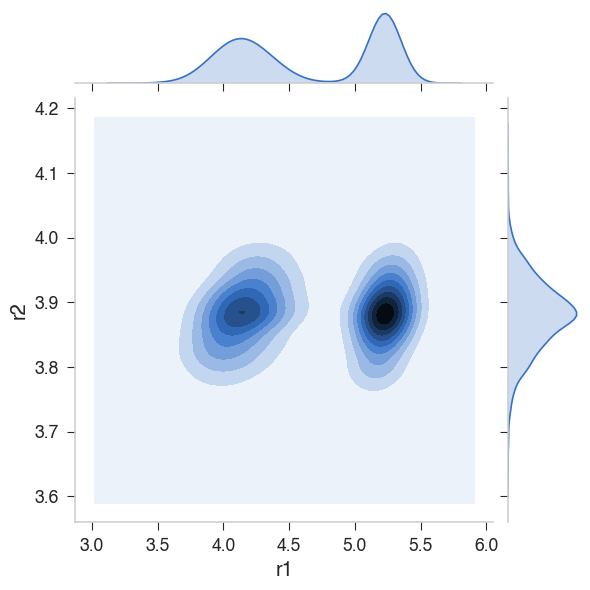

In [73]:
data_res = data.query("ResName == 'TYR'").reset_index(drop=True)
sns.jointplot("r1", "r2", kind="kde", data=data_res)

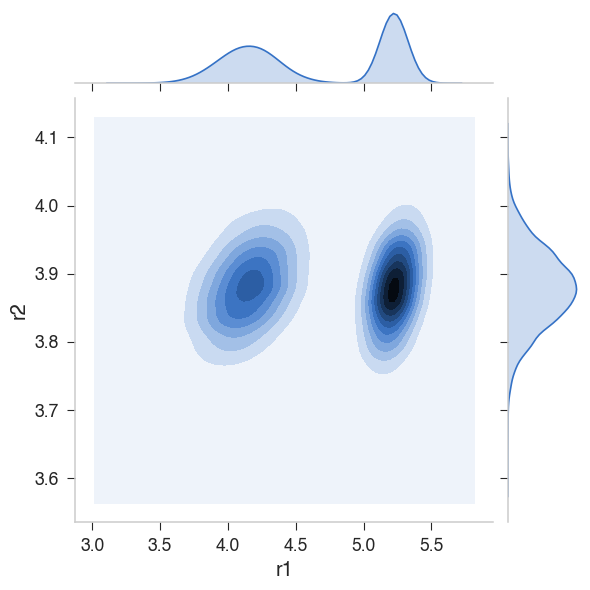

In [14]:
sns.jointplot("r1", "r2", kind="kde", data=sampled)

In [75]:
res_set = {}
res_set['GLY'] = {'CA', 'N', 'O', 'C'}
res_set['ALA'] = {'CA', 'CB', 'N', 'O', 'C'}
res_set['VAL'] = {'CA', 'CB', 'CG2', 'CG1', 'N', 'O', 'C'}
res_set['CYS'] = {'CA', 'CB', 'SG', 'N', 'O', 'C'}
res_set['PRO'] = {'CA', 'CB', 'CG', 'CD', 'N', 'O', 'C'}
res_set['LEU'] = {'CD1', 'CA', 'CD2', 'CB', 'CG', 'N', 'O', 'C'}
res_set['ILE'] = {'CD1', 'CA', 'CB', 'CG2', 'CG1', 'N', 'O', 'C'}
res_set['MET'] = {'CA', 'CB', 'SD', 'CG', 'CE', 'N', 'O', 'C'}
res_set['TRP'] = {'CD1', 'CA', 'CZ3', 'NE1', 'CD2', 'CB', 'CG', 'CZ2', 'CH2', 'CE3', 'N', 'O', 'CE2', 'C'}
res_set['PHE'] = {'CD1', 'CA', 'CD2', 'CB', 'CE1', 'CG', 'CZ', 'N', 'O', 'CE2', 'C'}


res_set['SER'] = {'CA', 'OG', 'CB', 'N', 'O', 'C'}
res_set['THR'] = {'CA', 'CB', 'CG2', 'N', 'OG1', 'O', 'C'}
res_set['TYR'] = {'CD1', 'CA', 'CD2', 'CB', 'CE1', 'OH', 'CG', 'CZ', 'N', 'O', 'CE2', 'C'}
res_set["GLN"] = {'CA', 'CB', 'CG', 'CD', 'OE1', 'NE2', 'N', 'O', 'C'}
res_set['ASN'] = {'CA', 'OD1', 'CB', 'CG', 'ND2', 'N', 'O', 'C'}


res_set['LYS'] = {'CA', 'CB', 'CE', 'CG', 'CD', 'NZ', 'N', 'O', 'C'}
res_set['ARG'] = {'CA', 'NE', 'CB', 'CG', 'CD', 'NH2', 'CZ', 'NH1', 'N', 'O', 'C'}
res_set['HIS'] = {'CA', 'ND1', 'CD2', 'CB', 'CE1', 'CG', 'NE2', 'N', 'O', 'C'}


res_set['ASP'] = {'OD2', 'CA', 'OD1', 'CB', 'CG', 'N', 'O', 'C'}
res_set['GLU'] = {'CA', 'OE2', 'CB', 'CG', 'CD', 'OE1', 'N', 'O', 'C'}

In [77]:
x = np.array([[5.46133935, 4.14118887, 5.53369196]])


n_features = 3
matrix_chol = gmm.precisions_cholesky_
n_components, _ = gmm.means_.shape
n_components, _, _ = matrix_chol.shape
log_det_chol = (np.sum(np.log(
    matrix_chol.reshape(
        n_components, -1)[:, ::n_features + 1]), 1))
log_det = log_det_chol

means = gmm.means_
precisions_chol = gmm.precisions_cholesky_



res = "TYR"
np.savetxt(f"/Users/weilu/opt/parameters/side_chain/{res}_means.txt", means, fmt='%10.8f')
np.savetxt(f"/Users/weilu/opt/parameters/side_chain/{res}_precisions_chol.txt", precisions_chol.reshape(3,9), fmt='%12.8f')
np.savetxt(f"/Users/weilu/opt/parameters/side_chain/{res}_log_det.txt", log_det, fmt='%10.8f')


means = np.loadtxt(f"/Users/weilu/opt/parameters/side_chain/{res}_means.txt")
precisions_chol = np.loadtxt(f"/Users/weilu/opt/parameters/side_chain/{res}_precisions_chol.txt").reshape(3,3,3)
log_det = np.loadtxt(f"/Users/weilu/opt/parameters/side_chain/{res}_log_det.txt")

dict_keys(['GLY', 'ALA', 'VAL', 'CYS', 'PRO', 'LEU', 'ILE', 'MET', 'TRP', 'PHE', 'SER', 'THR', 'TYR', 'GLN', 'ASN', 'LYS', 'ARG', 'HIS', 'ASP', 'GLU'])